<a href="https://colab.research.google.com/github/ManriquezJM/Deep-learning-multidrug-resistance/blob/main/examples/e_coli_multilabel_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 - Libraries

In [ ]:
 #Para manejar los archivos y, por ejemplo, exportar a su navegador
import glob                     # Para manejar los archivos y, por ejemplo, exportar a su navegador
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import graphviz # for showing model diagram

import sys
import os

import sklearn
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer

import tensorflow as tf
import keras
from keras import regularizers
from keras.models import load_model
from keras.optimizers import Adam
from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, LeakyReLU, ReLU
from keras.models import Model # for creating a Neural Network Autoencoder model
from keras import Input # for instantiating a keras tensor
from keras.utils import plot_model # for plotting model diagram

from kerastuner.tuners import BayesianOptimization
from tensorflow.keras import layers
from kerastuner import Objective
from tensorflow.keras.metrics import AUC

2023-09-24 02:15:01.220049: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-24 02:15:01.269069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 02:15:02.004626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_611365/2668894149.py:34: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc',multi_label=True),
      keras.metrics.AUC(name='prc', curve='PR',multi_label=True), # precision-recall curve
      keras.metrics.F1Score(name='f1_score', average='macro')
]

2023-09-23 20:23:44.535052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14231 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:c3:00.0, compute capability: 8.6


In [ ]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('No GPU found')

print('Device found: {}'.format(device_name))

2023-09-23 20:44:24.277438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 14231 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:c3:00.0, compute capability: 8.6
2023-09-23 20:44:24.286701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 14231 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:c3:00.0, compute capability: 8.6
2023-09-23 20:44:24.294210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 14231 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:c3:00.0, compute capability: 8.6


GPU disponible: /device:GPU:0
Dispositivo encontrado: /device:GPU:0


#1 - Load data

In [ ]:
driams = pd.read_csv('/home/jmanriquez/driams_datasets/e_coli/e_coli_driams_a_bin2_2000_10000Da_v2.csv')
   # Reemplazamos los perfiles de resistencia (variables dependientes) por 0 y 1
driams.drop(columns=['code', 'species', 'Ceftazidime','Gentamicin','Ertapenem','Clindamycin','Cefepime','Piperacillin-Tazobactam','Meropenem','Imipenem','Tobramycin','Fusidic acid','Oxacillin','Vancomycin'], inplace=True)
driams.dropna(axis=1, how="all", inplace=True)
driams.dropna(axis=0, how="any", inplace=True)
driams.head()

,2000,2002,2004,2006,2008,2010,2012,2014,2016,2018,...,9984,9986,9988,9990,9992,9994,9996,9998,Ciprofloxacin,Ceftriaxone
0,813.25,1006.0,1030.2,776.60,814.0,1046.0,1148.2,820.0,940.20,783.25,...,117.5,146.0,182.500000,180.333333,115.5,147.5,107.0,34.553199,0.0,1.0
1,110.80,103.4,110.5,105.20,95.8,123.6,85.5,91.4,91.80,94.20,...,261.0,180.0,213.500000,231.000000,195.0,250.0,227.5,108.607311,0.0,0.0
2,1676.40,1631.6,1670.2,1972.25,1983.8,2505.6,2457.0,2221.8,1926.25,1637.00,...,508.5,518.0,493.500000,526.666667,573.5,539.5,531.0,175.364330,0.0,0.0
3,496.20,429.2,475.0,448.75,522.2,515.4,474.0,550.5,497.00,525.40,...,1097.0,1163.0,1016.666667,957.000000,949.5,1075.5,931.0,292.014401,0.0,0.0
4,694.75,599.4,622.0,710.60,848.5,844.6,930.4,825.4,747.25,742.60,...,105.5,117.0,104.000000,128.500000,136.5,127.5,98.5,37.187957,0.0,0.0


In [ ]:
print('ceftriaxone samples \n',driams.Ceftriaxone.value_counts())
print('Ciprofloxacin samples \n',driams.Ciprofloxacin.value_counts())

datos de ceftriaxone 
 0.0    3821
1.0    1039
Name: Ceftriaxone, dtype: int64
datos de Ciprofloxacin 
 0.0    3411
1.0    1449
Name: Ciprofloxacin, dtype: int64


In [ ]:
X = driams.iloc[:, 0:4000].values  # variables independientes (espectros de masa)
y = driams.iloc[:, 4000:4002].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X)
y = np.asarray(y)

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0, stratify=y_train)

In [ ]:
# Normalize data
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.transform(X_val)

In [ ]:
# Transformation of the input variables from 2-dimensional to 3-dimensional to make them applicable to the CNN
sample_size = X_train.shape[0] # number of samples in the data set
time_steps  = X_train.shape[1] # number of attributes in the dataset
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
X_val_reshaped = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

# 2 - Keras Tuner

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    #input layer
    model.add(
        layers.Conv1D(
            filters=hp.Int("conv_filters", min_value=32, max_value=128, step=16),
            kernel_size=hp.Int("conv_kernel", min_value=2, max_value=11),
            activation="relu",
            input_shape=(n_timesteps,n_features),
        )
    )
    ######
    if hp.Boolean("maxpooling"):
        model.add(MaxPooling1D(pool_size=2))
    ######
    # Calculate optimal number of hidden convolutional layers
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=5)
    for i in range(num_hidden_layers):
      model.add(
          layers.Conv1D(filters=hp.Int(f"conv_filters_{i}", min_value=32, max_value=128, step=16),
          kernel_size=hp.Int(f"conv_kernel_{i}", min_value=2, max_value=11),
          activation="relu",))
      if hp.Boolean(f"maxpooling_{i}"):
        model.add(MaxPooling1D(pool_size=2))

    model.add(layers.Flatten())
    model.add(Dropout(0.5))
    #Calculate optimal number of hidden convolutional layers
    num_hidden_dense_layers = hp.Int('num_hidden_dense_layers', min_value=1, max_value=5)
    for i in range(num_hidden_dense_layers):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=256, step=16),
                                activation='relu'))

    #output layer
    model.add(layers.Dense(2, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-3, 1e-4])
        ),
        metrics=METRICS,
    )
    return model

In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective=Objective("val_f1_score", direction="max"),
    max_trials=20,
    executions_per_trial=15,
    directory="hyperparameter_search",
    project_name="e_coli_multi_label_bin2_2000da_10000da",
    overwrite=False,
)

INFO:tensorflow:Reloading Tuner from hyperparameter_search/e_coli_multi_label_bin2_2000da_10000da/tuner0.json


In [ ]:
#Calbacks
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.1, patience=3, min_lr=0.0000001, mode="max")
early_st = EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True, mode="max")

In [ ]:
tuner.search(X_train, y_train, verbose=0, epochs=100, validation_data=[X_val, y_val],callbacks=[reduce_lr, early_st])

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in hyperparameter_search/e_coli_multi_label_bin2_2000da_10000da
Showing 10 best trials
Objective(name="val_f1_score", direction="max")

Trial 08 summary
Hyperparameters:
conv_filters: 64
conv_kernel: 8
maxpooling: True
num_hidden_layers: 3
conv_filters_0: 80
conv_kernel_0: 7
maxpooling_0: True
num_hidden_dense_layers: 3
units_0: 144
learning_rate: 0.0001
conv_filters_1: 32
conv_kernel_1: 11
maxpooling_1: True
conv_filters_2: 80
conv_kernel_2: 2
maxpooling_2: True
conv_filters_3: 128
conv_kernel_3: 8
maxpooling_3: True
conv_filters_4: 80
conv_kernel_4: 11
maxpooling_4: True
units_1: 144
units_2: 192
units_3: 224
Score: 0.4561181445916494

Trial 04 summary
Hyperparameters:
conv_filters: 96
conv_kernel: 2
maxpooling: True
num_hidden_layers: 4
conv_filters_0: 64
conv_kernel_0: 9
maxpooling_0: True
num_hidden_dense_layers: 2
units_0: 192
learning_rate: 0.001
conv_filters_1: 64
conv_kernel_1: 3
maxpooling_1: False
conv_filters_2: 112
conv_kernel_2: 8
maxpooling_2: Tru

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3993, 64)          576       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1996, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1990, 80)          35920     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 995, 80)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 985, 32)           28192     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 492, 32)           0

## 2.1 - Optimized model test

In [ ]:
model = Sequential(name="e_coli_optimized_model")

model.add(Conv1D(filters=(64), kernel_size=(8), input_shape = (n_timesteps,n_features), name='Conv_1'))

model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))

model.add(Conv1D(filters=(80), kernel_size=(7),  name='Conv_2'))

model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D1"))

model.add(Conv1D(filters=(32), kernel_size=(11),   name='Conv_3'))

model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D2"))

model.add(Conv1D(filters=(80), kernel_size=(2),   name='Conv_3l'))

model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D2dl"))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(144, activation='relu', name="fully_connected_1"))
model.add(Dense(144, activation='relu',  name="fully_connected_2"))
model.add(Dense(192, activation='relu',  name="fully_connected_22"))
model.add(Dense(2, activation='sigmoid', name="OUT_Layer"))


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0000001)
early_st = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
adamw_optim = tf.keras.optimizers.experimental.AdamW(weight_decay=0.001, learning_rate=0.0001)

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics=METRICS)
model.summary()

Model: "Modelo_e_coli_multi_label_optimizado"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 3993, 64)          576       
                                                                 
 activation (Activation)     (None, 3993, 64)          0         
                                                                 
 MaxPooling1D (MaxPooling1D  (None, 1996, 64)          0         
 )                                                               
                                                                 
 Conv_2 (Conv1D)             (None, 1990, 80)          35920     
                                                                 
 activation_1 (Activation)   (None, 1990, 80)          0         
                                                                 
 MaxPooling1D1 (MaxPooling1  (None, 995, 80)           0         
 D)                           

In [ ]:
history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=2, validation_data=[X_val, y_val], callbacks=[early_st,reduce_lr])

Epoch 1/150


2023-09-23 20:24:30.958932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2023-09-23 20:24:32.406777: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-23 20:24:32.741975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-23 20:24:33.290275: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x26f972e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-23 20:24:33.290346: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-09-23 20:24:33.807499: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-23 20:24:34.417783: I tensor

110/110 - 15s - loss: 0.5853 - tp: 7.0000 - fp: 15.0000 - tn: 5192.0000 - fn: 1784.0000 - accuracy: 0.7429 - precision: 0.3182 - recall: 0.0039 - auc: 0.4731 - prc: 0.2489 - f1_score: 0.2357 - val_loss: 0.5663 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 579.0000 - val_fn: 199.0000 - val_accuracy: 0.7442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5189 - val_prc: 0.2689 - val_f1_score: 0.2297 - lr: 1.0000e-04 - 15s/epoch - 137ms/step
Epoch 2/150
110/110 - 2s - loss: 0.5578 - tp: 0.0000e+00 - fp: 1.0000 - tn: 5206.0000 - fn: 1791.0000 - accuracy: 0.7439 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5729 - prc: 0.3073 - f1_score: 0.2449 - val_loss: 0.5630 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 579.0000 - val_fn: 199.0000 - val_accuracy: 0.7442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5515 - val_prc: 0.2846 - val_f1_score: 0.2302 - lr: 1.0000e-04 - 2s/epoch - 18ms/step
Epoch 3/150
110/110 - 2s - loss: 0.5465 - tp: 

### 2.1.1 - History plot

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

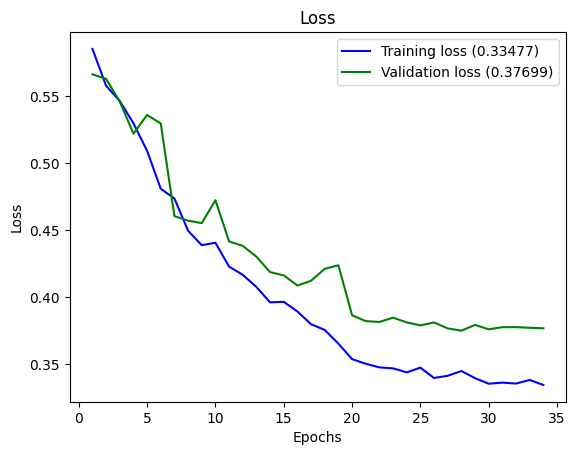

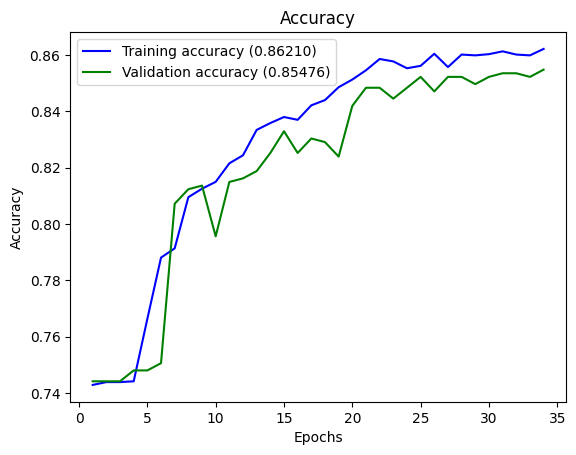

In [ ]:
plot_history(history)

## 2.2 - Evaluation of the optimized model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, average_precision_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score

y_pred = model.predict(X_test)

# Convert predicted and actual labels to binary arrays
y_pred_binary = (y_pred > 0.5)
y_test_binary = y_test

# Calculate accuracy, class accuracy, recall, F1-score and AUC-ROC
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, average='weighted')
recall = recall_score(y_test_binary, y_pred_binary, average='weighted')
f1 = f1_score(y_test_binary, y_pred_binary, average='weighted')
auc_roc = roc_auc_score(y_test_binary, y_pred)
prc = average_precision_score(y_test_binary, y_pred)
los
jaccard = jaccard_score(y_test_binary, y_pred_binary, average='weighted')
print("Hamming loss:", loss)
# Imprimir los resultados
print("Jaccard score:", jaccard)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('AUC-ROC:', auc_roc)
print('AUC-PRC:', prc)

31/31 [==============================] - 0s 4ms/step
Hamming loss: 0.15432098765432098
Jaccard score: 0.47577595405777695
Accuracy: 0.7458847736625515
Precision: 0.7923148906304831
Recall: 0.5421686746987951
F1-score: 0.6435332477697737
AUC-ROC: 0.84017007009277
AUC-PRC: 0.7403776250394293


In [ ]:
num_etiquetas = y_test.shape[1]  # Obtén el número de etiquetas
auc_scores = []

for i in range(num_etiquetas):
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    auc_scores.append(auc)
    print("AUC label %d: %f" % (i, auc))

AUC Etiqueta 0: 0.802634
AUC Etiqueta 1: 0.877706


In [ ]:
from sklearn.metrics import f1_score
f1_scores = []
for i in range(2):
    f1 = f1_score(y_test[:, i], y_pred_binary[:, i])
    f1_scores.append(f1)
    print("F1-Score Etiqueta %d: %f" % (i, f1))

# Calcula el promedio del F1-Score
f1_scores_avg = np.mean(f1_scores)
print("F1-Score mean: %f" % f1_scores_avg)

F1-Score Etiqueta 0: 0.608871
F1-Score Etiqueta 1: 0.691860
F1-Score Promedio: 0.650366


### 2.2.1 - AUROC Y AUPRC plot

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

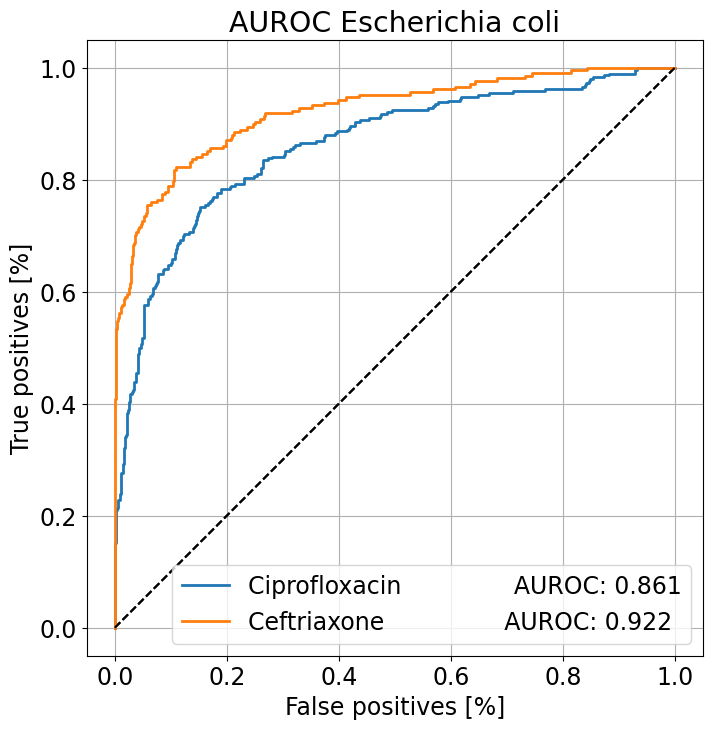

In [ ]:
from sklearn import metrics
fpr1, tpr1, _ = metrics.roc_curve(y_test[:, 0], y_pred[:, 0])
roc_auc1 = metrics.auc(fpr1, tpr1)
fpr2, tpr2, _ = metrics.roc_curve(y_test[:, 1], y_pred[:, 1])
roc_auc2 = metrics.auc(fpr2, tpr2)
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('AUROC Escherichia coli')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.3f" % roc_auc1 ,y_test[:, 0], y_pred[:, 0], color=colors[0])
plot_roc("Ceftriaxone                AUROC: %0.3f" % roc_auc2, y_test[:, 1], y_pred[:, 1], color=colors[1])
plt.legend(loc='lower right');

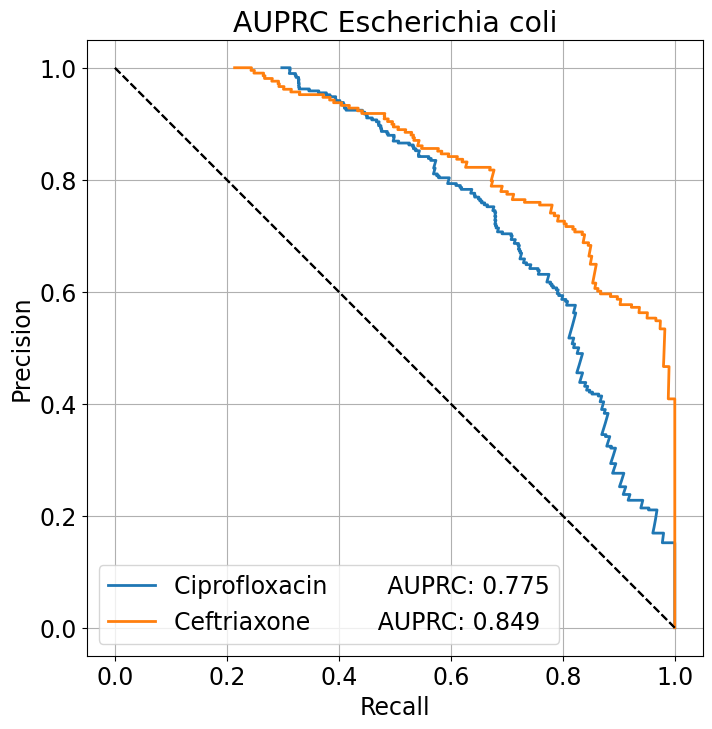

In [ ]:
precision1, recall1, _ = sklearn.metrics.precision_recall_curve(y_test[:, 0], y_pred[:, 0])
roc_auc1 = metrics.auc(recall1,precision1)
precision2, recall2, _ = sklearn.metrics.precision_recall_curve(y_test[:, 1], y_pred[:, 1])
roc_auc2 = metrics.auc(recall2,precision2 )
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('AUPRC Escherichia coli')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.3f" % roc_auc1, y_test[:, 0], y_pred[:, 0], color=colors[0])
plot_prc("Ceftriaxone         AUPRC: %0.3f" % roc_auc2, y_test[:, 1],  y_pred[:, 1], color=colors[1])

plt.legend(loc='lower left');

# 3 - XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, roc_auc_score, average_precision_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, classification_report, roc_auc_score, average_precision_score, hamming_loss

In [ ]:
driams = pd.read_csv('/home/jmanriquez/driams_datasets/e_coli/e_coli_driams_a_bin2_2000_10000Da_v2.csv')
driams.drop(columns=['code', 'species', 'Ceftazidime','Gentamicin','Ertapenem','Clindamycin','Cefepime','Piperacillin-Tazobactam','Meropenem','Imipenem','Tobramycin','Fusidic acid','Oxacillin','Vancomycin'], inplace=True)
driams.dropna(axis=1, how="all", inplace=True)
driams.dropna(axis=0, how="any", inplace=True)
driams.head()

,2000,2002,2004,2006,2008,2010,2012,2014,2016,2018,...,9984,9986,9988,9990,9992,9994,9996,9998,Ciprofloxacin,Ceftriaxone
0,813.25,1006.0,1030.2,776.60,814.0,1046.0,1148.2,820.0,940.20,783.25,...,117.5,146.0,182.500000,180.333333,115.5,147.5,107.0,34.553199,0.0,1.0
1,110.80,103.4,110.5,105.20,95.8,123.6,85.5,91.4,91.80,94.20,...,261.0,180.0,213.500000,231.000000,195.0,250.0,227.5,108.607311,0.0,0.0
2,1676.40,1631.6,1670.2,1972.25,1983.8,2505.6,2457.0,2221.8,1926.25,1637.00,...,508.5,518.0,493.500000,526.666667,573.5,539.5,531.0,175.364330,0.0,0.0
3,496.20,429.2,475.0,448.75,522.2,515.4,474.0,550.5,497.00,525.40,...,1097.0,1163.0,1016.666667,957.000000,949.5,1075.5,931.0,292.014401,0.0,0.0
4,694.75,599.4,622.0,710.60,848.5,844.6,930.4,825.4,747.25,742.60,...,105.5,117.0,104.000000,128.500000,136.5,127.5,98.5,37.187957,0.0,0.0


In [ ]:
X = driams.iloc[:, 0:4000].values  # variables independientes (espectros de masa)
y = driams.iloc[:, 4000:4002].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4432, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 52742, stratify=y_train)

In [ ]:
# Normalize data
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.transform(X_val)

In [ ]:
# Create a DMatrix object
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test)

In [ ]:
# define parameters
params = {
    'tree_method': 'gpu_hist',
    'objective': 'binary:logistic',
    'max_depth': 8,
    'learning_rate': 0.1,
    'eval_metric': 'logloss',
    'subsample':0.5,
    'gamma':0.1,
    'min_child_weight' : 2
}
# Train model

num_rounds = 300
model = xgb.train(params, train_dmatrix, num_rounds)

y_pred = model.predict(test_dmatrix)

threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

In [ ]:
# Ealuate the model
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary, average='weighted')
confusion_matrix = multilabel_confusion_matrix(y_test, y_pred_binary)
hamming_loss_score = hamming_loss(y_test, (y_pred_binary >= 0.5).astype(int))
auroc_scores = []
for i in range(y.shape[1]):
    auroc = roc_auc_score(y_test[:, i], y_pred_binary[:, i])
    auroc_scores.append(auroc)
a
auprc_scores = []
for i in range(y.shape[1]):
    auprc = average_precision_score(y_test[:, i], y_pred_binary[:, i])
    auprc_scores.append(auprc)

print('Confusion Matrix:')
print(confusion_matrix)
print('Classification Report:')
print(classification_report(y_test, y_pred_binary))
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

print("AUROC Scores:", auroc_scores)
print("AUPRC Scores:", auprc_scores)
print("Hamming Loss:", hamming_loss_score)

Confusion Matrix:
[[[650  32]
  [187 103]]

 [[758   6]
  [135  73]]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.36      0.48       290
           1       0.92      0.35      0.51       208

   micro avg       0.82      0.35      0.49       498
   macro avg       0.84      0.35      0.50       498
weighted avg       0.83      0.35      0.49       498
 samples avg       0.13      0.11      0.12       498

Accuracy: 0.7047325102880658
F1 Score: 0.49473203327760723
AUROC Scores: [0.654125796339367, 0.6715540676600885]
AUPRC Scores: [0.46337022846601394, 0.4631951206318295]
Hamming Loss: 0.18518518518518517


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
